# 1. BTC/USD Dataset (Data split 7:3)

In [1]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [3]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [4]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [5]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [6]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [7]:
split_size1 = int(0.7 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [8]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [9]:
N_EPOCHS = 100
N_NEURONS = 50
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 56355472.0000
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 29226488.0000
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16144173.0000
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1724360.7500
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1106377.6250
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1107332.7500
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 910297.3750
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1048013.3125
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 757394.3750
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 814572.5000
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 828473.6875
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 816735.3750
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 811901.2500
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [10]:
model_preds1 = model.predict(X_test).reshape(-1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.6122496166555726
RMSE: 1359.6123908217053
MAE: 954.5182732877829


In [12]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [13]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 67201.8203125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [69440.        68374.        67652.4       68352.2       67548.
 67768.5       67201.8203125] -> Prediction: 67993.421875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting on: 
 [68374.        67652.4       68352.2       67548.        67768.5
 67201.8203125 67993.421875 ] -> Prediction: 66787.984375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       67201.8203125
 67993.421875  66787.984375 ] -> Prediction: 66526.1796875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicting on: 
 [68352.2       67548.        67768.5       67201.8203125 67993.421875
 66787.984375  66526.1796875] -> Prediction: 66952.890625

1

In [14]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [15]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [16]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

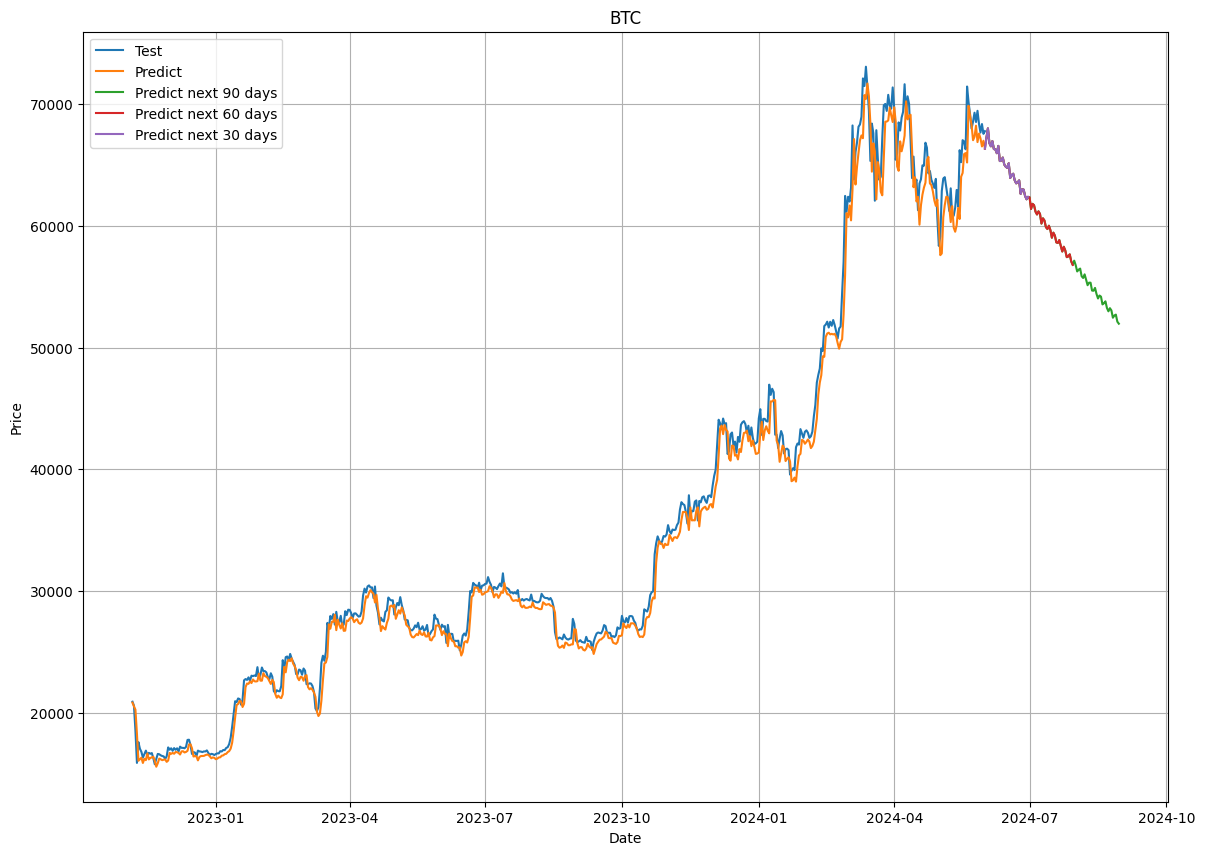

In [17]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 2. ETH/USD Dataset (Data split 7:3)

In [18]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [20]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [21]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [22]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [23]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [24]:
split_size1 = int(0.7 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [25]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [26]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 82765.5391
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8127.1758
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10835.6787
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6387.1689
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4515.5112
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3955.3213
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3813.3406
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3620.2639
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4066.8923
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7578.8945
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5351.2319
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4570.2920
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3995.8098 
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4361.2412
Epoch 15/100

In [27]:
model_preds1 = model.predict(X_test).reshape(-1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.531324710782177
RMSE: 79.98688907670093
MAE: 54.32394028507459


In [29]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [30]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3767.2958984375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3767.29589844] -> Prediction: 3800.11474609375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3767.29589844 3800.11474609] -> Prediction: 3738.9912109375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3767.29589844
 3800.11474609 3738.99121094] -> Prediction: 3682.456298828125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3767.29589844 3800.11474609
 3738.99121094 3682.45629883] -> Prediction: 

In [31]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [32]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [33]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

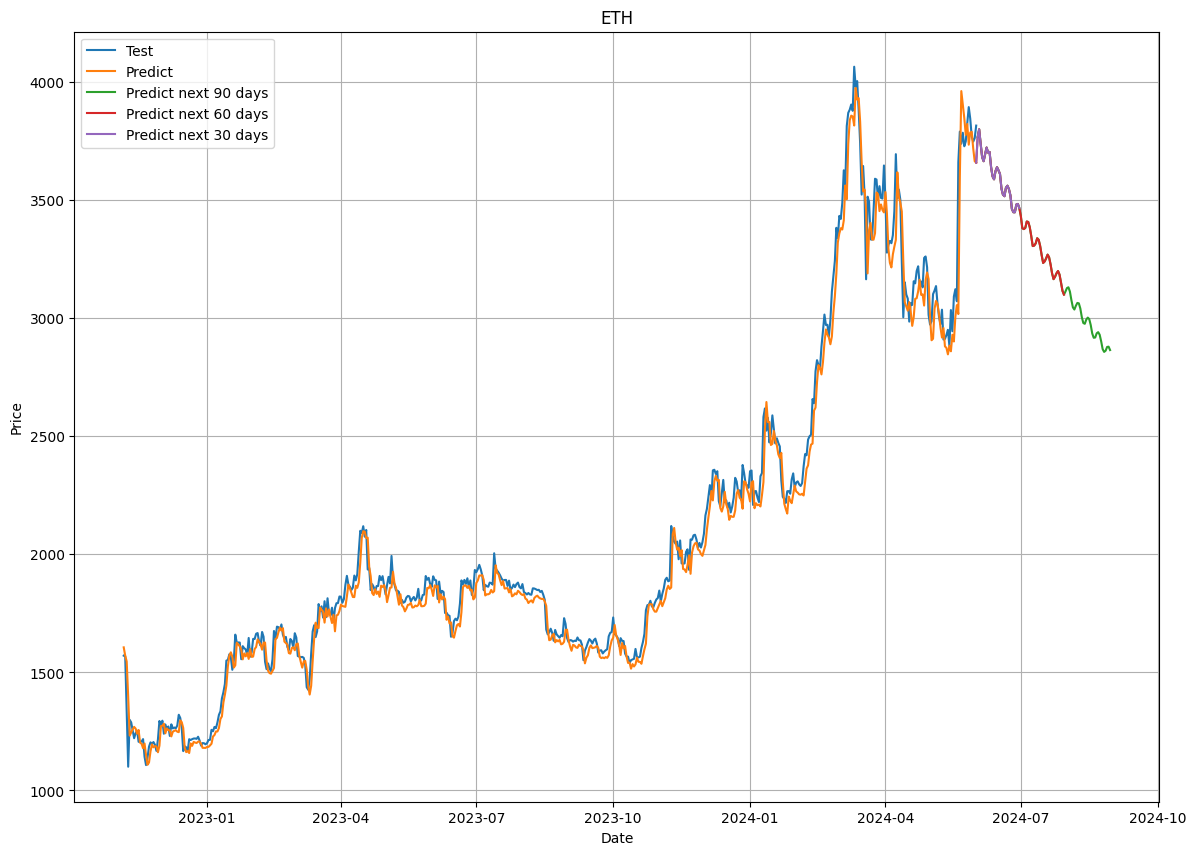

In [34]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. BNB/USD Dataset (Data split 7:3)

In [35]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [37]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [38]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [39]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [40]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [41]:
split_size1 = int(0.7 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [42]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [43]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 5745.7656
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1049.4395
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 236.5503
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 308.1265
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1012.0056
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 240.3095
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 160.5142
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 135.6662
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 164.2428
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 120.5019
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 105.9325
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 96.1540
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 103.5585
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 135.4662
Epoch 15/100
21/21 ━━━━━━━

In [44]:
model_preds1 = model.predict(X_test).reshape(-1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.000751451057847
RMSE: 11.231637548062709
MAE: 6.783699817192263


In [46]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [47]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 592.1388549804688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        592.13885498] -> Prediction: 598.861572265625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 592.13885498 598.86157227] -> Prediction: 592.578125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        592.13885498
 598.86157227 592.578125  ] -> Prediction: 588.904052734375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [595.         593.8        601.8        592.13885498 598.86157227
 592.578125   588.90405273] -> Prediction: 589.1286010742188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [48]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [49]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [50]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

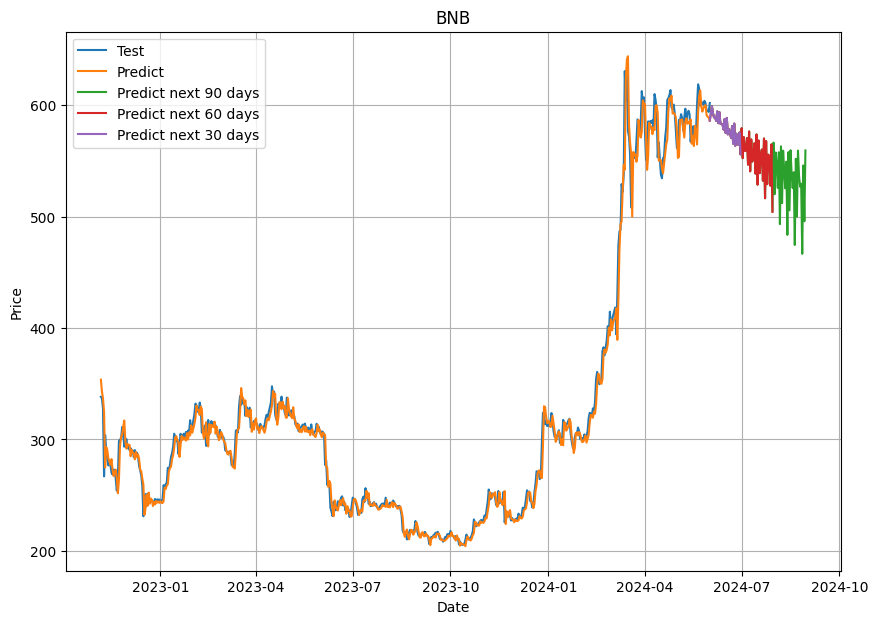

In [51]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 4. BTC/USD Dataset (Data split 8:2)

In [52]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [54]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [55]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [56]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [57]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [58]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [59]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [60]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 65509588.0000
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7203835.0000
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2194852.7500
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1259749.6250
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1380279.2500
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1694940.3750
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2010727.0000 
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1165037.3750
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1315526.0000
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1051512.5000
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1162729.3750
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1566701.1250
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1526344.7500
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

In [61]:
model_preds1 = model.predict(X_test).reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.261875027777691
RMSE: 1417.1038621322095
MAE: 989.3373255956266


In [63]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [64]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 69655.1875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [69440.     68374.     67652.4    68352.2    67548.     67768.5
 69655.1875] -> Prediction: 70572.4140625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [68374.        67652.4       68352.2       67548.        67768.5
 69655.1875    70572.4140625] -> Prediction: 69276.5859375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       69655.1875
 70572.4140625 69276.5859375] -> Prediction: 68389.5703125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicting on: 
 [68352.2       67548.        67768.5       69655.1875    70572.4140625
 69276.5859375 68389.5703125] -> Prediction: 69138.28125

1/1 ━━━━━━━━━━━━━━━━━━

In [65]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [66]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [67]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

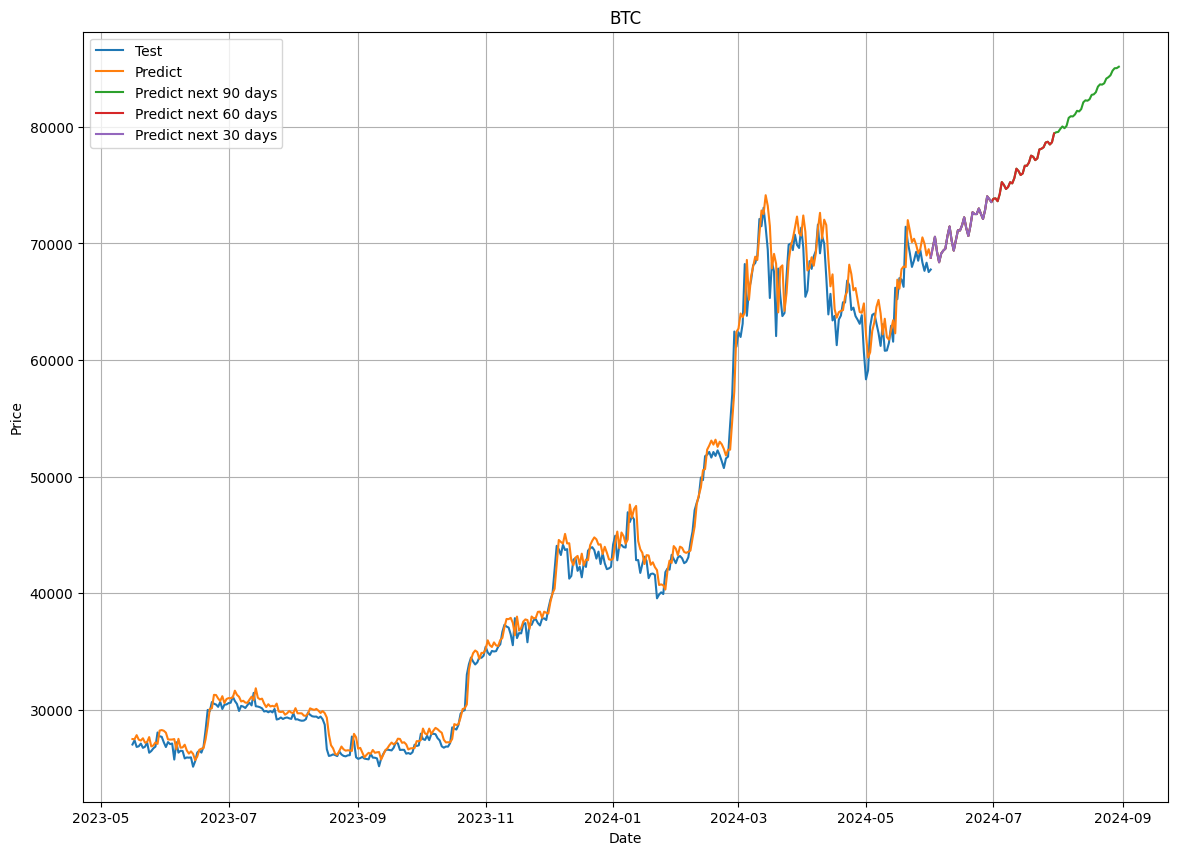

In [68]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 5. ETH/USD Dataset (Data split 8:2)

In [69]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [71]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [72]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [73]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [74]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [75]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [76]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [77]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 94759.3281
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17041.0703
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 44072.6406
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 37245.7539
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 50183.8984
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11206.2266
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6870.4683
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11971.1660
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6259.7427
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13935.6904
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16482.0566
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5931.7456
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5955.1606
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4455.2241
Epoch

In [78]:
model_preds1 = model.predict(X_test).reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step 


In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.9906802385962934
RMSE: 78.58080481130048
MAE: 49.91808031525376


In [80]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [81]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3791.929443359375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3791.92944336] -> Prediction: 3853.170166015625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3791.92944336 3853.17016602] -> Prediction: 3801.57470703125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3791.92944336
 3853.17016602 3801.57470703] -> Prediction: 3732.947998046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3791.92944336 3853.17016602
 3801.57470703 3732.94799805] -> Predicti

In [82]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [83]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [84]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

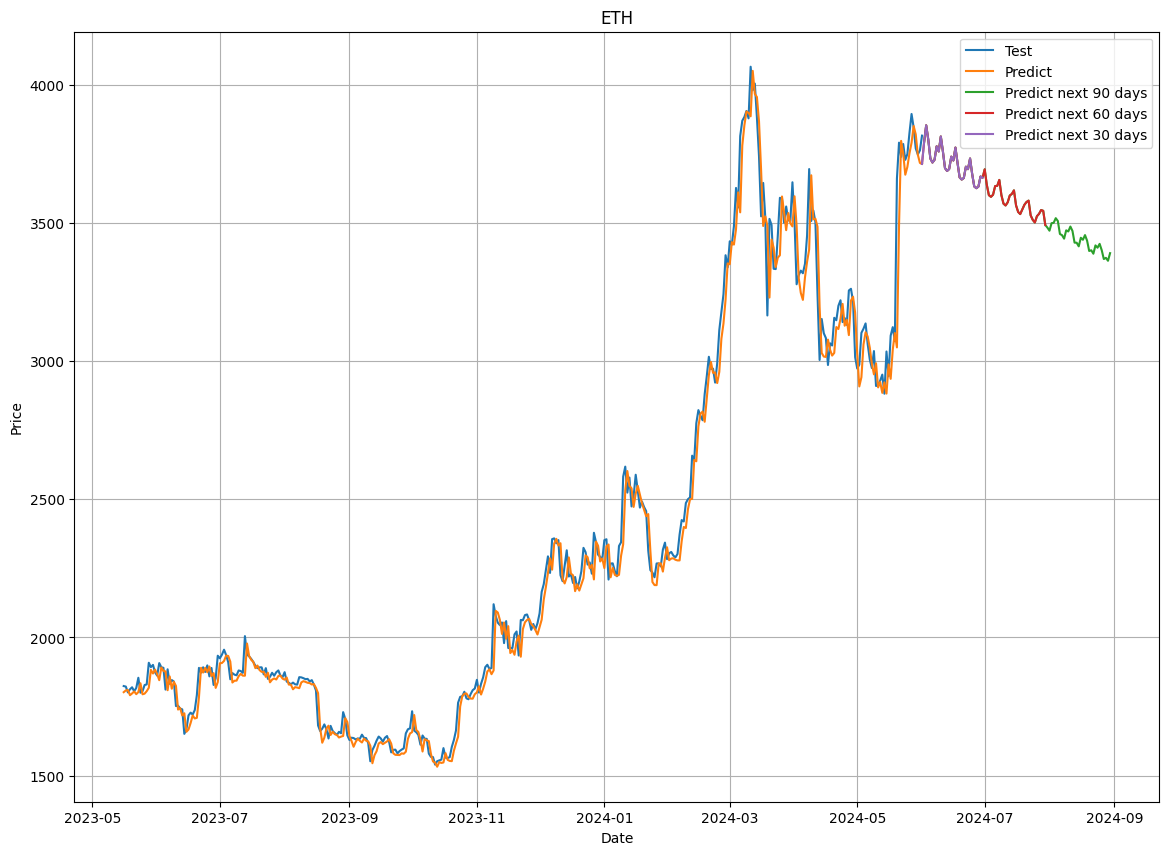

In [85]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 6. BNB/USD Dataset (Data split 8:2)

In [86]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [88]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [89]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [90]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [91]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [92]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [93]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [94]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 12647.6387
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2035.3660
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 266.1149
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 750.8038
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1992.8455
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 452.4650
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1420.8252
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 606.5725
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 443.2035
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 794.5123
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 659.4570
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 238.7645
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 203.8836
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 146.2367
Epoch 15/100
24/24 ━━━━

In [95]:
model_preds1 = model.predict(X_test).reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step 


In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.862179965574464
RMSE: 11.907834658349813
MAE: 6.7598280465945235


In [97]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [98]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 594.7312622070312

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        594.73126221] -> Prediction: 600.9666137695312

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 594.73126221 600.96661377] -> Prediction: 594.8919677734375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        594.73126221
 600.96661377 594.89196777] -> Prediction: 591.5153198242188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicting on: 
 [595.         593.8        601.8        594.73126221 600.96661377
 594.89196777 591.51531982] -> Prediction: 590.1054077148438

1/1 ━━━━━━━━━━━━━━━━

In [99]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [100]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [101]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

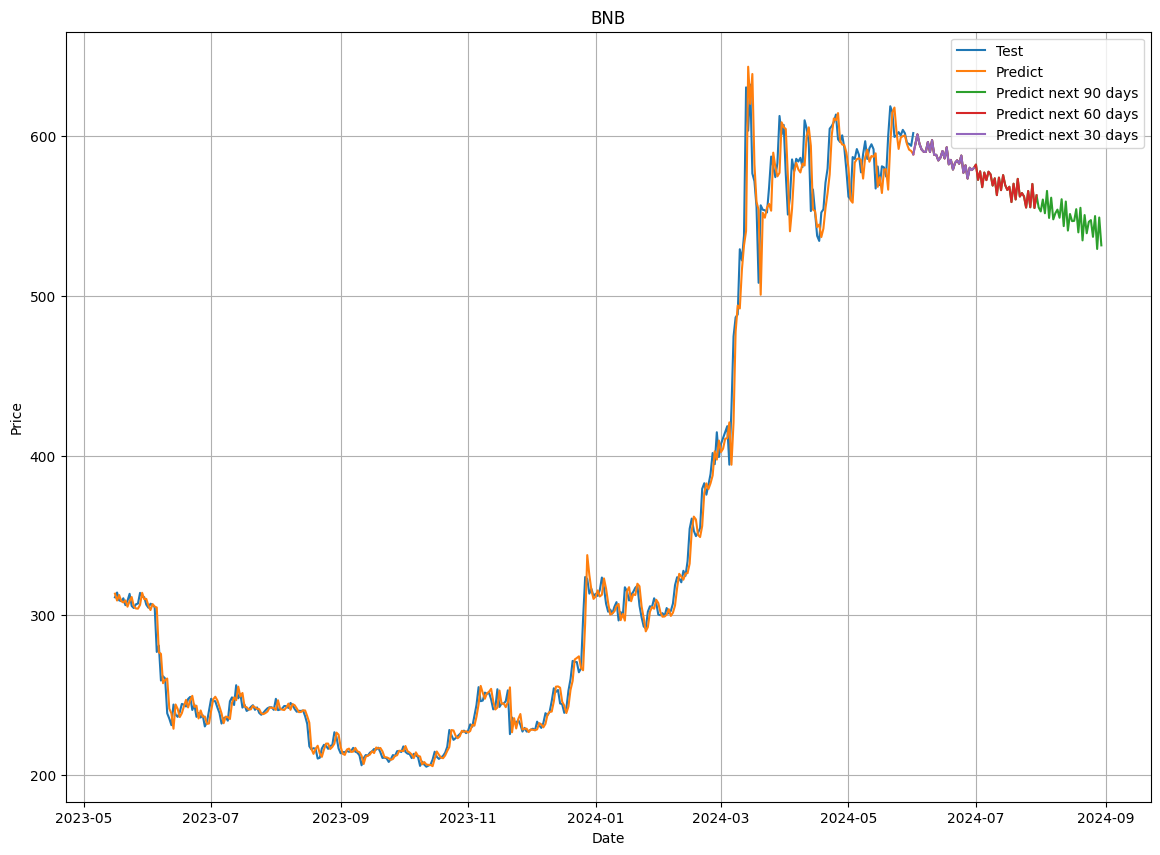

In [102]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 7. BTC/USD Dataset (Data split 9:1)

In [103]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [105]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [106]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [107]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [108]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [109]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [110]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [111]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 27011874.0000
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1857708.2500
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1844594.1250
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1492385.0000
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1702513.5000
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2375317.0000
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1298140.8750
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1292242.6250
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1142639.2500
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1186529.0000
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1435750.0000
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1377910.5000
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1307063.3750
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12

In [112]:
model_preds1 = model.predict(X_test).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


In [113]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.3730975654641937
RMSE: 1800.2938622267195
MAE: 1337.989571126302


In [114]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [115]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 69254.921875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [69440.       68374.       67652.4      68352.2      67548.
 67768.5      69254.921875] -> Prediction: 70036.96875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [68374.       67652.4      68352.2      67548.       67768.5
 69254.921875 70036.96875 ] -> Prediction: 69008.015625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [67652.4      68352.2      67548.       67768.5      69254.921875
 70036.96875  69008.015625] -> Prediction: 68672.8828125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [68352.2       67548.        67768.5       69254.921875  70036.96875
 69008.015625  68672.8828125] -> Prediction: 69276.8984375

1/1 ━━━━━━━━━━━━━━━━━

In [116]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [117]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [118]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

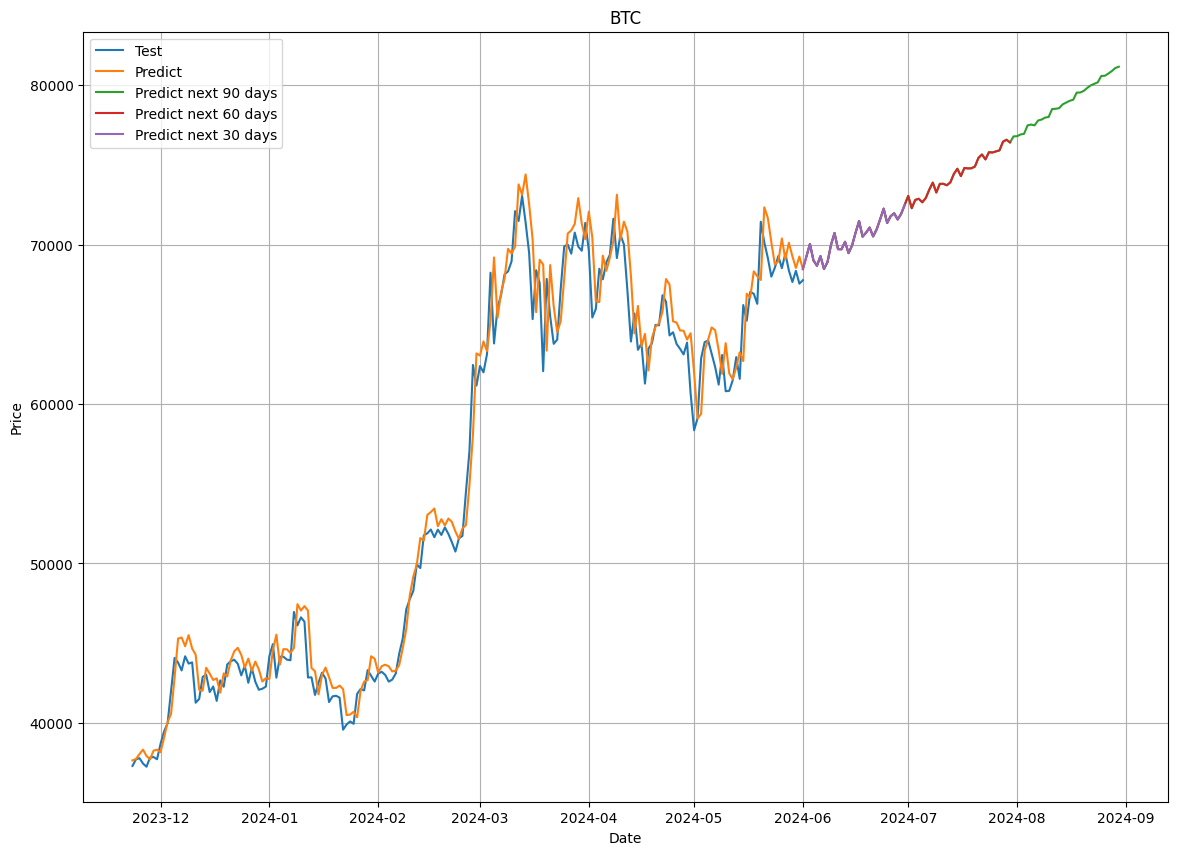

In [119]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 8. ETH/USD Dataset (Data split 9:1)

In [120]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [121]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [122]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [123]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [124]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [125]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [126]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [127]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [128]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 188546.5312
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13823.6807
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12234.6660
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7267.0845
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6042.7583
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5370.5845
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4810.7183
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5774.7915
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5173.7017
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7746.7671
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4929.2168
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4518.1562
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4435.3672
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6889.9478
Epoch 15/1

In [129]:
model_preds1 = model.predict(X_test).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  


In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 3.1997792528548286
RMSE: 126.8730231989674
MAE: 94.92360229492188


In [131]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [132]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3752.568115234375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3752.56811523] -> Prediction: 3771.939453125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3752.56811523 3771.93945312] -> Prediction: 3725.099365234375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3752.56811523
 3771.93945312 3725.09936523] -> Prediction: 3679.10986328125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3752.56811523 3771.93945312
 3725.09936523 3679.10986328] -> Prediction

In [133]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [134]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [135]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

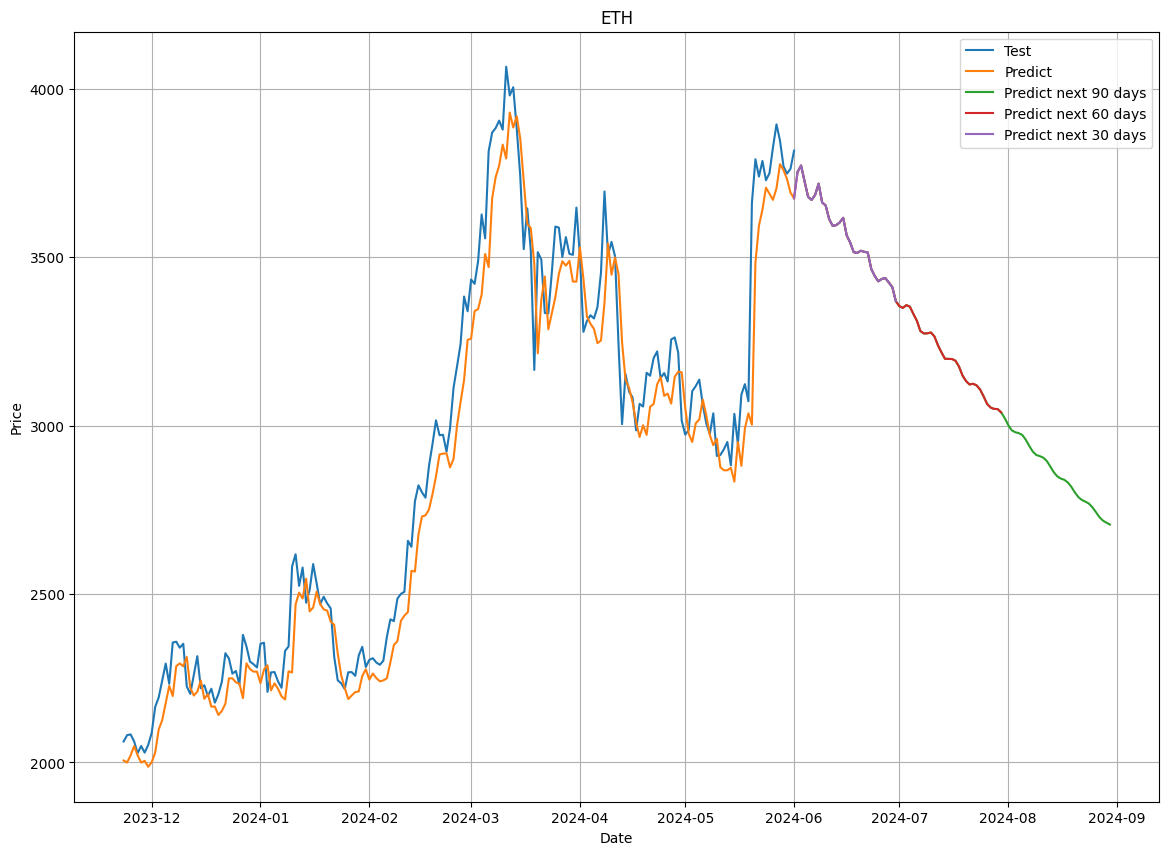

In [136]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 9. BNB/USD Dataset (Data split 9:1)

In [137]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [139]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [140]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [141]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [142]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [143]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [144]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 64 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [145]:
N_EPOCHS = 100
N_NEURONS = 50 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_dataset,
            epochs=N_EPOCHS,
           verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - loss: 9853.6465
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1466.5240
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 221.7683
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 244.1035
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 259.3775
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 138.4190
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 119.3507
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 117.9069
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 129.1675
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 135.5799
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 129.4634
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 107.6340
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 111.6662
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 102.9256
Epoch 15/100
27/27 ━━━━━━━

In [146]:
model_preds1 = model.predict(X_test).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


In [147]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.1126102583811797
RMSE: 15.300401159978845
MAE: 9.461809984842935


In [148]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [149]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 598.0696411132812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        598.06964111] -> Prediction: 602.8749389648438

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 598.06964111 602.87493896] -> Prediction: 599.9092407226562

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        598.06964111
 602.87493896 599.90924072] -> Prediction: 594.7494506835938

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [595.         593.8        601.8        598.06964111 602.87493896
 599.90924072 594.74945068] -> Prediction: 594.1643676757812

1/1 ━━━━━━━━━━━━━━━

In [150]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [151]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

In [152]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, model_preds1[-1])

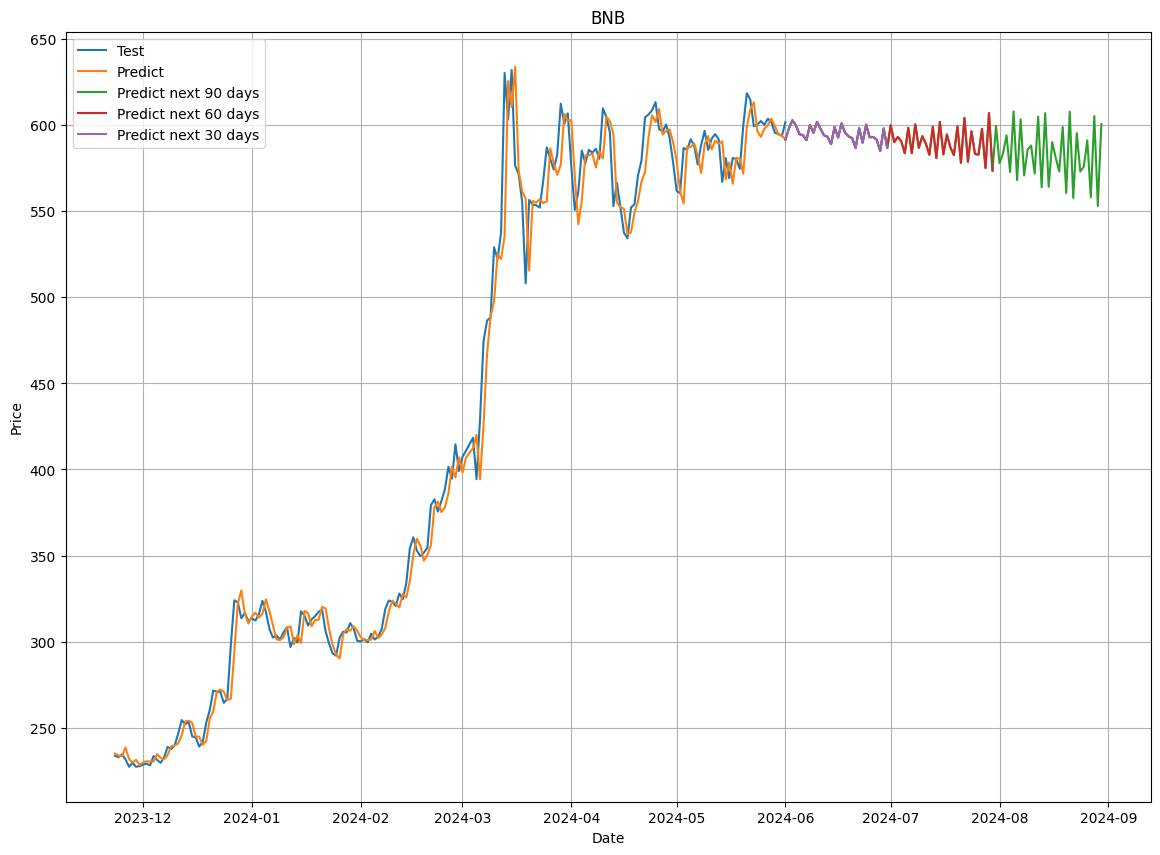

In [153]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')
plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()